In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import interp1d, splrep, splev
import pandas as pd
from scipy import interpolate

%load_ext autoreload
%autoreload 2
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def fill_nan(A):
    inds = np.arange(A.shape[0]) 
    good = np.where(np.isfinite(A))
    if(len(good[0]) <= 1):
        return A
   
    # linearly interpolate and then fill the extremes with the mean (relatively similar to)
    # what kalman does 
    f = interpolate.interp1d(inds[good], A[good],kind="linear",bounds_error=False,fill_value="extrapolate")
    B = np.where(np.isfinite(A),A,f(inds))
    B = np.where(np.isfinite(B),B,np.nanmean(B))
    return B

def mean_perc(ts):
    ts = ts[ts > np.percentile(ts,5)]
    ts = ts[ts < np.percentile(ts,95)]
    return np.mean(ts)

def center_ts(res):
    res.shape

    scale = (res[:,(NECK*3):(NECK*3+3)] - res[:,(MHIP*3):(MHIP*3+3)])[:,:2]
    scale = np.sqrt(np.sum(scale**2,axis=1))
    scale = mean_perc(scale)
    
    X = mean_perc(res[:,RANK*3])
    Y = mean_perc(res[:,RANK*3+1])
    
    for i in range(25):
        res[:,(i*3):(i*3+3)] = res[:,(i*3):(i*3+3)] - np.hstack([X,Y,0])[None,:]
    return res /scale #[:,None]

def plot_ts(res):
    # Features to plot for diagnostics
    PLOT_COLS = {
        "Left knee": LKNE,
        "Right knee": RKNE,
        "Left hip": LHIP,
        "Right hip": RHIP,
        "Nose": NOSE,
    }

    for name, col in PLOT_COLS.items():
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.title(name,fontsize=24)
        plt.xlabel("frame",fontsize=17)
        plt.ylabel("position",fontsize=17)
        plt.plot(res[:,[col*3,]], linestyle="-", linewidth=2.5)
        plt.plot(res[:,[col*3+1,]], linestyle="-", linewidth=2.5)
        plt.legend(['x', 'y'],loc=1)

def get_segments(res, magnitude = 1):
    nose_y = res[:,[NOSE*3+1,]]
    x=range(len(nose_y))
    f = splrep(x, nose_y, s=magnitude)
    nose_y_smooth = splev(x, f)
    peaks,_ = peakdet(nose_y_smooth, np.sqrt(magnitude)*(nose_y.max() - nose_y.min())/3  )

    plt.title("Peaks of the nose",fontsize=24)
    plt.xlabel("frame",fontsize=17)
    plt.ylabel("position",fontsize=17)
    plt.plot(nose_y, linestyle="-", linewidth=2.5)
    plt.plot(nose_y_smooth, linestyle="-", linewidth=2.5)
    for i in range(peaks.shape[0]):
        plt.axvline(x=peaks[i,0],linewidth=2, color='g', linestyle="--")
    plt.show()

    n = peaks.shape[0]

    # TODO we can get a better estimate of breaks from multiple signals at once
    breaks = peaks[:,0].astype(np.uint16)
    breaks.sort()

    return breaks

def get_angle_stats(A, B, C, res, breaks, name = None):
    langle = get_angle(A, B, C, res)
    minv = []
    maxv = []
    for i in range(len(breaks)-1):
        y = (langle[breaks[i]:breaks[i+1]])*180/np.pi
        minv.append(y.min())
        maxv.append(y.max())
    return {
        "{}_max".format(name): max(maxv),
        "{}_min".format(name): max(minv),
        "{}_max_sd".format(name): np.array(maxv).std(),
        "{}_min_sd".format(name): np.array(minv).std(),
    }
    
def get_angles_results(res, breaks):
    results = {}
    results.update(get_angle_stats(LANK, LKNE, LHIP, res, breaks, name="left_knee"))
    results.update(get_angle_stats(RANK, RKNE, RHIP, res, breaks, name="right_knee"))
    results.update(get_angle_stats(LKNE, LHIP, NECK, res, breaks, name="left_hip"))
    results.update(get_angle_stats(RKNE, RHIP, NECK, res, breaks, name="right_hip"))
    res_tmp = res.copy()
    ground = np.zeros([res_tmp.shape[0],3])
    ground[:,1] = ground[:,1] - 1
    res_tmp = np.hstack([res_tmp, ground])
    results.update(get_angle_stats(NECK, MHIP, 25, res_tmp, breaks, name="trunk"))
    return results

def get_time_results(res, breaks):
    times = []
    speeds = []

    for i in range(len(breaks)-1):
        time = (breaks[i+1] - breaks[i])/FPS
        speed = 1/time

        times.append(time)
        speeds.append(speed)

    first = breaks[0]
    last = breaks[-1]
    n = len(breaks)
    total_time = n*(last-first)/((n-1)*FPS)

    return {
        "n": len(breaks),
        "time": total_time,
        "speed": round(5/total_time,2),
        "time_sd": np.array(times).std(),
        "speed_sd": np.array(speeds).std(),
    }

def get_joint_speed(joint, res):
    n = res.shape[0]
    return res[1:n,(joint*3):(joint*3+3)] - res[0:(n-1),(joint*3):(joint*3+3)]

def get_speed_stats(joint, res, breaks, name="pelvic"):
    trunk_speed = get_joint_speed(joint, res)[:,0:2]
    trunk_speed_mag = np.sqrt(np.sum(trunk_speed**2, axis=1))
    
    n = trunk_speed.shape[0]
    trunk_acc = trunk_speed[1:n,:] - trunk_speed[0:(n-1),:]
    trunk_acc_mag = np.sqrt(np.sum(trunk_acc**2, axis=1))
    
    first = breaks[0]
    last = breaks[-1]
    
    trunk_speed_mag = trunk_speed_mag[first:last]
    trunk_speed_mag = trunk_speed_mag[trunk_speed_mag < np.percentile(trunk_speed_mag, 95)] # remove outliers
    
    trunk_acc_mag = trunk_acc_mag[first:last]
    trunk_acc_mag = trunk_acc_mag[trunk_acc_mag < np.percentile(trunk_acc_mag, 95)] # remove outliers
    
    return {
        "{}_avg_speed".format(name): trunk_speed_mag.mean(),
        "{}_max_speed".format(name): trunk_speed_mag.max(),
        "{}_avg_acc".format(name): trunk_acc_mag.mean(),
        "{}_max_acc".format(name): trunk_acc_mag.max(),
    }
    
def get_acceleration_results(res, breaks):
    results = {}
    results.update(get_speed_stats(MHIP, res, breaks, name="pelvic"))
    results.update(get_speed_stats(NECK, res, breaks, name="neck"))
    return results

CqjNQOqS


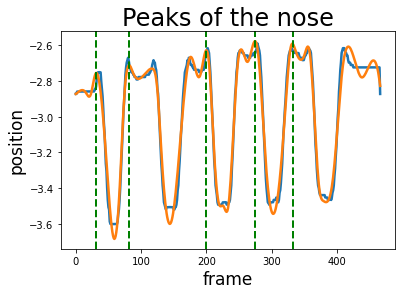

cIZijMLk
Skipped cIZijMLk
['cIZijMLk']


In [12]:
def process_subject(subjectid):
    res = np.load("videos/np/{}.npy".format(subjectid))
    
    first = 0
    last = res.shape[0]
    magnitude = 1
    
    if subjectid == "k4Zz5q1I":
        first = 75
        last = 240
        magnitude = 0.1
    if subjectid == "hozGKSGr":
        first = 60
        last = 250
        magnitude = 0.1
    if subjectid == "zyW3PPtt":
        res[res[:,NOSE*3+1] < -1,NOSE*3+1] = np.NaN
        
        
    res = res[first:last,:]

    res[res < 0.5] = np.NaN 
    res = np.apply_along_axis(fill_nan,arr=res,axis=0)
    #plt.plot(res[:,RANK])

    res = center_ts(res)
    breaks = get_segments(res, magnitude=magnitude)
    #plot_ts(res)

    results = {
        "subjectid": subjectid,
    }
    results.update(get_time_results(res, breaks))
    results.update(get_angles_results(res, breaks))
    results.update(get_acceleration_results(res, breaks))
    return results

subjects = os.listdir("videos/keypoints")
# subjects = [
#     "z7T3lqIX",
#     "k4Zz5q1I",
#     "hozGKSGr",
#     "zyW3PPtt"
# ]

skipped = []
tofix = []

all_res = []

# Convert OpenPose frames to a numpy array
for subjectid in subjects:
    print(subjectid)
    try:
        results = process_subject(subjectid)
    except Exception as e:
        skipped.append(subjectid)
        print("Skipped " + subjectid)
        continue
    all_res.append(results)    
print(skipped)

In [13]:
res_df = pd.DataFrame(all_res)
res_df

,subjectid,n,time,speed,time_sd,speed_sd,left_knee_max,left_knee_min,left_knee_max_sd,left_knee_min_sd,...,trunk_max_sd,trunk_min_sd,pelvic_avg_speed,pelvic_max_speed,pelvic_avg_acc,pelvic_max_acc,neck_avg_speed,neck_max_speed,neck_avg_acc,neck_max_acc
0,CqjNQOqS,5,12.541667,0.4,0.868388,0.126133,179.957995,130.019839,0.219807,2.276066,...,0.765473,5.329434,0.017944,0.055057,0.017111,0.042863,0.03049,0.082008,0.025383,0.066294


In [14]:
res_df.to_csv("results-new.csv")